# 1. Dataset

In [2]:
import pandas as pd

## 1.1. Carga del dataset

In [5]:
uri = 'https://raw.githubusercontent.com/maribcs/mgp-bayesian-network-retail/main/data/db_mgp_t1.csv'
df = pd.read_csv(uri, sep=',')
df.head()

,row_num,flag_nuevo,fl_omni,fl_fcom,fl_tienda,flag_tienetarjeta,flag_metodopago,flag_tienepromocion,Genero,NSE,Rango_edad,estado_marital,flag_tiene_hijo,rango_gasto
0,27,1,0,0,1,0,0,0,M,C,26-35 AÑOS,C,1,gasto bajo
1,36,1,0,0,1,0,0,0,F,B,36-45 AÑOS,C,0,gasto alto
2,62,1,0,0,1,1,1,0,F,B,26-35 AÑOS,S,0,gasto medio
3,65,0,0,0,1,0,0,0,M,C,36-45 AÑOS,C,1,gasto bajo
4,99,0,0,0,1,1,0,0,F,B,36-45 AÑOS,S,0,gasto alto


In [6]:
# Tamaño del dataset
df.shape

(990392, 14)

## 1.2. Pre pocesamiento del dataset

In [10]:
# Seleccionar columnas a utilizar
df_model = df[['NSE','Rango_edad','Genero','estado_marital','flag_tienetarjeta','flag_nuevo','flag_metodopago','flag_tienepromocion','fl_fcom','rango_gasto']]

In [11]:
# Renombrar columnas

# 1. NSE: Nivel socioeconómico
# 2. E: Rango de edad
# 3. G: Género
# 4. EC: Estado civil
# 5. TR: Tiene tarjeta del retail
# 6. TC: Tipo de cliente
# 7. PTR: Usa tarjeta del retail
# 8. PP: Producto en promoción
# 9. CC: Canal de compra
# 10. C: Rango de compra

df_model = df_model.rename(columns = {'Rango_edad':'E','Genero':'G','estado_marital':'EC','flag_tienetarjeta':'TR','flag_nuevo':'TC','flag_metodopago':'PTR','flag_tienepromocion':'PP','fl_fcom':'CC','rango_gasto':'C'})
df_model.head()

,NSE,E,G,EC,TR,TC,PTR,PP,CC,C
0,C,26-35 AÑOS,M,C,0,1,0,0,0,gasto bajo
1,B,36-45 AÑOS,F,C,0,1,0,0,0,gasto alto
2,B,26-35 AÑOS,F,S,1,1,1,0,0,gasto medio
3,C,36-45 AÑOS,M,C,0,0,0,0,0,gasto bajo
4,B,36-45 AÑOS,F,S,1,0,0,0,0,gasto alto


In [12]:
# Estandarizar valores
# NSE
df_model['NSE'] = df_model['NSE'].replace({'A':0,'B':1,'C':2,'D':3,'E':4})
# Rango de edad
df_model['E'] = df_model['E'].replace({'16-25 AÑOS':0,'26-35 AÑOS':1,'36-45 AÑOS':2,'46-55 AÑOS':3,'56 A MÁS':4})
# Género
df_model['G'] = df_model['G'].replace({'M':0,'F':1})
# Estado civil
df_model['EC'] = df_model['EC'].replace({'S':0,'C':1})
# Rango compra
df_model['C'] = df_model['C'].replace({'gasto bajo':0,'gasto medio':1,'gasto alto':2})


# 2. Construcción del modelo

In [13]:
!pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.5 MB/s eta 0:00:00


In [14]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import TreeSearch
from pgmpy.inference import VariableElimination

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

## 2.1. Definición de nodos

In [16]:
model = BayesianNetwork([('NSE', 'TR'), ('TR', 'PTR'), ('PTR', 'PP'), ('CC', 'PP'),('PP', 'C'),('CC', 'C'),('E', 'TC'),('G', 'TC'),('EC', 'TC'),('TC', 'C')])

## 2.2. DAG del modelo

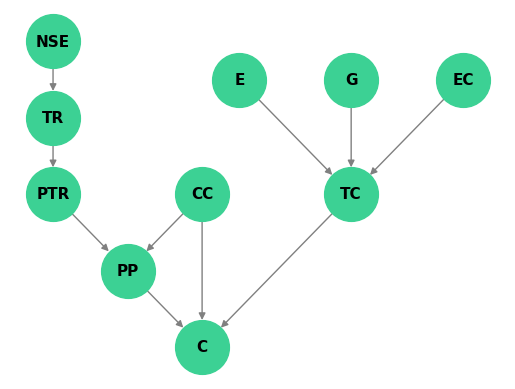

In [50]:
pos = {'NSE': (1, 0), 'TR': (1, -2), 'PTR': (1, -4), 'PP': (2, -6), 'CC': (3, -4), 'E': (3.5, -1),'G': (5, -1),'EC': (6.5, -1),'TC': (5, -4),'C': (3, -8)}

nx.draw_networkx(model, pos=pos, with_labels=True, node_color='#3cd194',
                 node_size=1500, font_size=11, font_weight='bold', edge_color='gray')

plt.axis('off')
plt.show()

## 2.3. Aprendizaje de parámetros

In [51]:
pe = ParameterEstimator(model, df_model)

### 2.3.1. Frecuencia de estados

In [52]:
# 1. NSE: Nivel socioeconómico (Incondicional)
print(pe.state_counts('NSE'))

      NSE
0  180269
1  447575
2  295641
3   55556
4   11351


In [55]:
# 2. E: Rango de edad (Incondicional)
print(pe.state_counts('E'))

        E
0    8247
1  261838
2  320229
3  227152
4  172926


In [54]:
# 3. G: Género (Incondicional)
print(pe.state_counts('G'))

        G
0  397432
1  592960


In [56]:
# 4. EC: Estado civil (Incondicional)
print(pe.state_counts('EC'))

       EC
0  581322
1  409070


In [57]:
# 5. TR: Tiene tarjeta del retail (Condicional)
print(pe.state_counts('TR'))

NSE       0       1       2      3     4
TR                                      
0     72371  172164  126285  27136  5990
1    107898  275411  169356  28420  5361


In [58]:
# 6. TC: Tipo de cliente (Condicional)
print(pe.state_counts('TC'))

E      0                    1                          2                       \
EC     0         1          0            1             0             1          
G      0     1   0   1      0      1     0      1      0      1      0      1   
TC                                                                              
0   1984  3307   6  23  63538  95850  4496  10922  54271  77219  26081  45386   
1   1435  1455  12  25  38748  38635  3322   6327  36774  36967  19178  24353   

E       3                          4                       
EC      0             1            0             1         
G       0      1      0      1     0      1      0      1  
TC                                                         
0   17180  34674  30547  52733  4524  18050  22021  48474  
1   14912  21603  25799  29704  5656  14540  26948  32713  


In [59]:
# 7. PTR: Usa tarjeta del retail (Condicional)
print(pe.state_counts('PTR'))

TR        0       1
PTR                
0    377676  288425
1     26270  298021


In [60]:
# 8. PP: Producto en promoción o no (Condicional)
print(pe.state_counts('PP'))

CC        0              1       
PTR       0       1      0      1
PP                               
0    580214  199949  73406  78375
1      8744   28316   3737  17651


In [61]:
# 9. CC: Canal de compra (Incondicional)
print(pe.state_counts('CC'))

       CC
0  817223
1  173169


In [62]:
# 10. C: Rango de compra (Condicional)
print(pe.state_counts('C'))

CC       0                           1                    
PP       0              1            0             1      
TC       0       1      0     1      0      1      0     1
C                                                         
0   206831  210555   8149  3773  27691  12711   2058   552
1   104249   68459   6968  1867  22244   6314   2682   410
2   133439   56630  14172  2131  68243  14578  14560  1126


### 2.3.2. Maxima Verosimilitud

In [63]:
mle = MaximumLikelihoodEstimator(model, df_model)

In [64]:
# 1. NSE: Nivel socioeconómico
print(mle.estimate_cpd('NSE'))

+--------+-----------+
| NSE(0) | 0.182018  |
+--------+-----------+
| NSE(1) | 0.451917  |
+--------+-----------+
| NSE(2) | 0.298509  |
+--------+-----------+
| NSE(3) | 0.056095  |
+--------+-----------+
| NSE(4) | 0.0114611 |
+--------+-----------+


In [65]:
# 2. E: Rango d Edad
print(mle.estimate_cpd('E'))

+------+------------+
| E(0) | 0.00832701 |
+------+------------+
| E(1) | 0.264378   |
+------+------------+
| E(2) | 0.323336   |
+------+------------+
| E(3) | 0.229356   |
+------+------------+
| E(4) | 0.174604   |
+------+------------+


In [66]:
# 3. G: Género
print(mle.estimate_cpd('G'))

+------+----------+
| G(0) | 0.401288 |
+------+----------+
| G(1) | 0.598712 |
+------+----------+


In [67]:
# 4. EC: Estado civil
print(mle.estimate_cpd('EC'))

+-------+----------+
| EC(0) | 0.586962 |
+-------+----------+
| EC(1) | 0.413038 |
+-------+----------+


In [68]:
# 5. TR: Tiene o no tarjeta del retail
cpd_tr = mle.estimate_cpd('TR')
print(cpd_tr)

+-------+---------------------+-----+---------------------+
| NSE   | NSE(0)              | ... | NSE(4)              |
+-------+---------------------+-----+---------------------+
| TR(0) | 0.40146114972624247 | ... | 0.5277068099726896  |
+-------+---------------------+-----+---------------------+
| TR(1) | 0.5985388502737575  | ... | 0.47229319002731035 |
+-------+---------------------+-----+---------------------+


In [71]:
# 6. TC: Tipo de cliente (Condicional)
cpd_tc = mle.estimate_cpd('TC')
print(cpd_tc)

+-------+--------------------+-----+---------------------+
| E     | E(0)               | ... | E(4)                |
+-------+--------------------+-----+---------------------+
| EC    | EC(0)              | ... | EC(1)               |
+-------+--------------------+-----+---------------------+
| G     | G(0)               | ... | G(1)                |
+-------+--------------------+-----+---------------------+
| TC(0) | 0.5802866335185727 | ... | 0.5970660327392316  |
+-------+--------------------+-----+---------------------+
| TC(1) | 0.4197133664814273 | ... | 0.40293396726076836 |
+-------+--------------------+-----+---------------------+


In [73]:
# 7. PTR: Usa tarjeta del retail
print(mle.estimate_cpd('PTR'))

+--------+---------------------+---------------------+
| TR     | TR(0)               | TR(1)               |
+--------+---------------------+---------------------+
| PTR(0) | 0.9349665549355607  | 0.49181851355453016 |
+--------+---------------------+---------------------+
| PTR(1) | 0.06503344506443931 | 0.5081814864454698  |
+--------+---------------------+---------------------+


In [74]:
# 8. PP: Producto en promoción
cpd_pp = mle.estimate_cpd('PP')
print(cpd_pp)

+-------+----------------------+-----+---------------------+
| CC    | CC(0)                | ... | CC(1)               |
+-------+----------------------+-----+---------------------+
| PTR   | PTR(0)               | ... | PTR(1)              |
+-------+----------------------+-----+---------------------+
| PP(0) | 0.9851534404830226   | ... | 0.8161851998417096  |
+-------+----------------------+-----+---------------------+
| PP(1) | 0.014846559516977442 | ... | 0.18381480015829046 |
+-------+----------------------+-----+---------------------+


In [78]:
# 9. CC: Canal de compra
print(mle.estimate_cpd('CC'))

+-------+----------+
| CC(0) | 0.825151 |
+-------+----------+
| CC(1) | 0.174849 |
+-------+----------+


In [79]:
# 10. C: Rango de compra
cpd_c = mle.estimate_cpd('C')
print(cpd_c)

+------+---------------------+-----+---------------------+
| CC   | CC(0)               | ... | CC(1)               |
+------+---------------------+-----+---------------------+
| PP   | PP(0)               | ... | PP(1)               |
+------+---------------------+-----+---------------------+
| TC   | TC(0)               | ... | TC(1)               |
+------+---------------------+-----+---------------------+
| C(0) | 0.4652916973177749  | ... | 0.26436781609195403 |
+------+---------------------+-----+---------------------+
| C(1) | 0.23452090911749554 | ... | 0.19636015325670497 |
+------+---------------------+-----+---------------------+
| C(2) | 0.3001873935647295  | ... | 0.539272030651341   |
+------+---------------------+-----+---------------------+


### 2.3.2. Estimar los parámetros bayesianos

In [81]:
be = BayesianEstimator(model, df_model)

In [84]:
# 1. NSE: Nivel socioeconómico
cpd_nse = be.estimate_cpd('NSE', prior_type='BDeu')
print(cpd_nse)

+--------+-----------+
| NSE(0) | 0.182018  |
+--------+-----------+
| NSE(1) | 0.451916  |
+--------+-----------+
| NSE(2) | 0.298509  |
+--------+-----------+
| NSE(3) | 0.0560957 |
+--------+-----------+
| NSE(4) | 0.0114621 |
+--------+-----------+


In [91]:
# 2. E: Rango de edad
cpd_e = be.estimate_cpd('E', prior_type='BDeu')
print(cpd_e)

+------+------------+
| E(0) | 0.00832894 |
+------+------------+
| E(1) | 0.264377   |
+------+------------+
| E(2) | 0.323334   |
+------+------------+
| E(3) | 0.229355   |
+------+------------+
| E(4) | 0.174604   |
+------+------------+


In [85]:
# 3. G: Género
cpd_g = be.estimate_cpd('G', prior_type='BDeu')
print(cpd_g)

+------+----------+
| G(0) | 0.401288 |
+------+----------+
| G(1) | 0.598712 |
+------+----------+


In [86]:
# 4. EC: Estado civil
cpd_ec = be.estimate_cpd('EC', prior_type='BDeu')
print(cpd_ec)

+-------+----------+
| EC(0) | 0.586961 |
+-------+----------+
| EC(1) | 0.413039 |
+-------+----------+


In [101]:
# 5. TR: Tiene tarjeta del retail
cpd_tr = be.estimate_cpd('TR', prior_type='BDeu')
print(cpd_tr)

+-------+---------------------+-----+--------------------+
| NSE   | NSE(0)              | ... | NSE(4)             |
+-------+---------------------+-----+--------------------+
| TR(0) | 0.40146169634437234 | ... | 0.5277043692741367 |
+-------+---------------------+-----+--------------------+
| TR(1) | 0.5985383036556277  | ... | 0.4722956307258633 |
+-------+---------------------+-----+--------------------+


In [102]:
for i in range(0, len(cpd_tr.values)):
  for j in range(0, len(cpd_tr.values[i])):
    print('tr_',i,'nse_',j,': ',cpd_tr.values[i][j])

tr_ 0 nse_ 0 :  0.40146169634437234
tr_ 0 nse_ 1 :  0.38465981196489535
tr_ 0 nse_ 2 :  0.4271568315733218
tr_ 0 nse_ 3 :  0.4884443004481884
tr_ 0 nse_ 4 :  0.5277043692741367
tr_ 1 nse_ 0 :  0.5985383036556277
tr_ 1 nse_ 1 :  0.6153401880351047
tr_ 1 nse_ 2 :  0.5728431684266783
tr_ 1 nse_ 3 :  0.5115556995518117
tr_ 1 nse_ 4 :  0.4722956307258633


In [103]:
# 6. TC: Tipo de cliente (Condicional)
cpd_tc = be.estimate_cpd('TC', prior_type='BDeu')
print(cpd_tc)

+-------+---------------------+-----+---------------------+
| E     | E(0)                | ... | E(4)                |
+-------+---------------------+-----+---------------------+
| EC    | EC(0)               | ... | EC(1)               |
+-------+---------------------+-----+---------------------+
| G     | G(0)                | ... | G(1)                |
+-------+---------------------+-----+---------------------+
| TC(0) | 0.5802807633252907  | ... | 0.5970657338436762  |
+-------+---------------------+-----+---------------------+
| TC(1) | 0.41971923667470934 | ... | 0.40293426615632383 |
+-------+---------------------+-----+---------------------+


In [104]:
for i in range(0, len(cpd_tc.values)):
  for j in range(0, len(cpd_tc.values[i])):
    for k in range(0, len(cpd_tc.values[i][j])):
      for l in range(0, len(cpd_tc.values[i][j][k])):
        print('tc_',i,'e_',j,'ec_',k,'g_',l,': ',cpd_tc.values[i][j][k][l])

tc_ 0 e_ 0 ec_ 0 g_ 0 :  0.5802807633252907
tc_ 0 e_ 0 ec_ 0 g_ 1 :  0.6944459026720563
tc_ 0 e_ 0 ec_ 1 g_ 0 :  0.3356164383561644
tc_ 0 e_ 0 ec_ 1 g_ 1 :  0.4792746113989637
tc_ 0 e_ 1 ec_ 0 g_ 0 :  0.6211795329284239
tc_ 0 e_ 1 ec_ 0 g_ 1 :  0.7127184951509552
tc_ 0 e_ 1 ec_ 1 g_ 0 :  0.5750807405749369
tc_ 0 e_ 1 ec_ 1 g_ 1 :  0.6331941968491384
tc_ 0 e_ 2 ec_ 0 g_ 0 :  0.5960895818288159
tc_ 0 e_ 2 ec_ 0 g_ 1 :  0.6762558977109766
tc_ 0 e_ 2 ec_ 1 g_ 0 :  0.5762606538994791
tc_ 0 e_ 2 ec_ 1 g_ 1 :  0.6507974347300839
tc_ 0 e_ 3 ec_ 0 g_ 0 :  0.5353356339926306
tc_ 0 e_ 3 ec_ 0 g_ 1 :  0.6161304079357112
tc_ 0 e_ 3 ec_ 1 g_ 0 :  0.5421323513099807
tc_ 0 e_ 3 ec_ 1 g_ 1 :  0.6396759353326318
tc_ 0 e_ 4 ec_ 0 g_ 0 :  0.4444021512241841
tc_ 0 e_ 4 ec_ 0 g_ 1 :  0.5538504614110048
tc_ 0 e_ 4 ec_ 1 g_ 0 :  0.4496929195362396
tc_ 0 e_ 4 ec_ 1 g_ 1 :  0.5970657338436762
tc_ 1 e_ 0 ec_ 0 g_ 0 :  0.41971923667470934
tc_ 1 e_ 0 ec_ 0 g_ 1 :  0.3055540973279437
tc_ 1 e_ 0 ec_ 1 g_ 0 :  0.6643

In [105]:
# 7. PTR: Usa tarjeta del retail
cpd_ptr = be.estimate_cpd('PTR', prior_type='BDeu')
print(cpd_ptr)

+--------+---------------------+---------------------+
| TR     | TR(0)               | TR(1)               |
+--------+---------------------+---------------------+
| PTR(0) | 0.9349638629676803  | 0.49181854843178896 |
+--------+---------------------+---------------------+
| PTR(1) | 0.06503613703231971 | 0.508181451568211   |
+--------+---------------------+---------------------+


In [106]:
# 8. PP: Producto en promoción
cpd_pp = be.estimate_cpd('PP', prior_type='BDeu')
print(cpd_pp)

+-------+----------------------+-----+---------------------+
| CC    | CC(0)                | ... | CC(1)               |
+-------+----------------------+-----+---------------------+
| PTR   | PTR(0)               | ... | PTR(1)              |
+-------+----------------------+-----+---------------------+
| PP(0) | 0.9851524107992191   | ... | 0.8161810840152144  |
+-------+----------------------+-----+---------------------+
| PP(1) | 0.014847589200780869 | ... | 0.18381891598478556 |
+-------+----------------------+-----+---------------------+


In [107]:
for i in range(0, len(cpd_pp.values)):
  for j in range(0, len(cpd_pp.values[i])):
    for k in range(0, len(cpd_pp.values[i][j])):
        print('pp_',i,'cc_',j,'ptr_',k,': ',cpd_pp.values[i][j][k])

pp_ 0 cc_ 0 ptr_ 0 :  0.9851524107992191
pp_ 0 cc_ 0 ptr_ 1 :  0.875949138341739
pp_ 0 cc_ 1 ptr_ 0 :  0.951550180343966
pp_ 0 cc_ 1 ptr_ 1 :  0.8161810840152144
pp_ 1 cc_ 0 ptr_ 0 :  0.014847589200780869
pp_ 1 cc_ 0 ptr_ 1 :  0.12405086165826092
pp_ 1 cc_ 1 ptr_ 0 :  0.04844981965603399
pp_ 1 cc_ 1 ptr_ 1 :  0.18381891598478556


In [108]:
# 9. CC: Canal de compra
cpd_cc = be.estimate_cpd('CC', prior_type='BDeu')
print(cpd_cc)

+-------+----------+
| CC(0) | 0.825149 |
+-------+----------+
| CC(1) | 0.174851 |
+-------+----------+


In [109]:
# 10. C: Rango de compra
cpd_c = be.estimate_cpd('C', prior_type='BDeu')
print(cpd_c)

+------+---------------------+-----+---------------------+
| CC   | CC(0)               | ... | CC(1)               |
+------+---------------------+-----+---------------------+
| PP   | PP(0)               | ... | PP(1)               |
+------+---------------------+-----+---------------------+
| TC   | TC(0)               | ... | TC(1)               |
+------+---------------------+-----+---------------------+
| C(0) | 0.46529151178271005 | ... | 0.2643884533285455  |
+------+---------------------+-----+---------------------+
| C(1) | 0.23452104804896595 | ... | 0.19640114110160192 |
+------+---------------------+-----+---------------------+
| C(2) | 0.30018744016832405 | ... | 0.5392104055698526  |
+------+---------------------+-----+---------------------+


In [110]:
for i in range(0, len(cpd_c.values)):
  for j in range(0, len(cpd_c.values[i])):
    for k in range(0, len(cpd_c.values[i][j])):
      for l in range(0, len(cpd_c.values[i][j][k])):
        print('c_',i,'cc_',j,'pp_',k,'tc_',l,': ',cpd_c.values[i][j][k][l])

c_ 0 cc_ 0 pp_ 0 tc_ 0 :  0.46529151178271005
c_ 0 cc_ 0 pp_ 0 tc_ 1 :  0.6273158949985669
c_ 0 cc_ 0 pp_ 1 tc_ 0 :  0.2782284967231002
c_ 0 cc_ 0 pp_ 1 tc_ 1 :  0.48551085948348427
c_ 0 cc_ 1 pp_ 0 tc_ 0 :  0.2343165554120581
c_ 0 cc_ 1 pp_ 0 tc_ 1 :  0.37826896155796685
c_ 0 cc_ 1 pp_ 1 tc_ 0 :  0.10663946547499542
c_ 0 cc_ 1 pp_ 1 tc_ 1 :  0.2643884533285455
c_ 1 cc_ 0 pp_ 0 tc_ 0 :  0.23452104804896595
c_ 1 cc_ 0 pp_ 0 tc_ 1 :  0.20396336849825417
c_ 1 cc_ 0 pp_ 1 tc_ 0 :  0.2379070518428738
c_ 1 cc_ 0 pp_ 1 tc_ 1 :  0.2402597054455578
c_ 1 cc_ 1 pp_ 0 tc_ 0 :  0.18822531006206353
c_ 1 cc_ 1 pp_ 0 tc_ 1 :  0.18790259483413868
c_ 1 cc_ 1 pp_ 1 tc_ 0 :  0.13897002471854322
c_ 1 cc_ 1 pp_ 1 tc_ 1 :  0.19640114110160192
c_ 2 cc_ 0 pp_ 0 tc_ 0 :  0.30018744016832405
c_ 2 cc_ 0 pp_ 0 tc_ 1 :  0.16872073650317904
c_ 2 cc_ 0 pp_ 1 tc_ 0 :  0.483864451434026
c_ 2 cc_ 0 pp_ 1 tc_ 1 :  0.2742294350709579
c_ 2 cc_ 1 pp_ 0 tc_ 0 :  0.5774581345258784
c_ 2 cc_ 1 pp_ 0 tc_ 1 :  0.4338284436078945

In [122]:
model.fit(df_model, estimator=BayesianEstimator, prior_type='BDeu')

In [123]:
for cpd in model.get_cpds():
    print(cpd)

+--------+-----------+
| NSE(0) | 0.182018  |
+--------+-----------+
| NSE(1) | 0.451916  |
+--------+-----------+
| NSE(2) | 0.298509  |
+--------+-----------+
| NSE(3) | 0.0560957 |
+--------+-----------+
| NSE(4) | 0.0114621 |
+--------+-----------+
+-------+---------------------+-----+--------------------+
| NSE   | NSE(0)              | ... | NSE(4)             |
+-------+---------------------+-----+--------------------+
| TR(0) | 0.40146169634437234 | ... | 0.5277043692741367 |
+-------+---------------------+-----+--------------------+
| TR(1) | 0.5985383036556277  | ... | 0.4722956307258633 |
+-------+---------------------+-----+--------------------+
+--------+---------------------+---------------------+
| TR     | TR(0)               | TR(1)               |
+--------+---------------------+---------------------+
| PTR(0) | 0.9349638629676803  | 0.49181854843178896 |
+--------+---------------------+---------------------+
| PTR(1) | 0.06503613703231971 | 0.508181451568211   |
+---

## 2.4. Aprendizaje estructurado

### 2.4.2. Grafico aciciclo dirigido

Building tree:   0%|          | 0/45.0 [00:00<?, ?it/s]

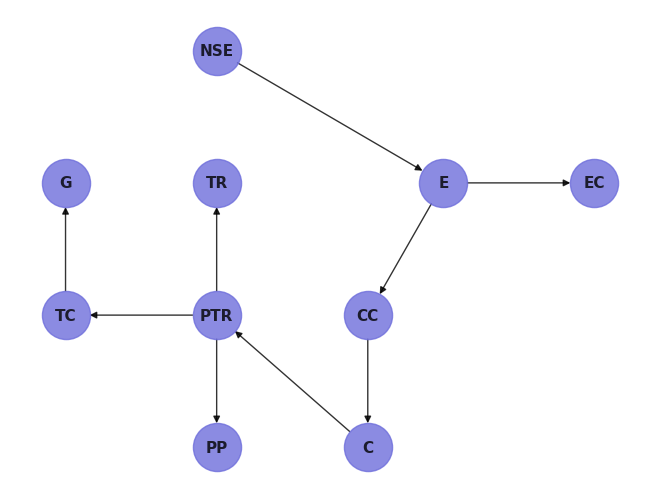

In [114]:
# NSE
ts = TreeSearch(df_model, root_node='NSE')
dag = ts.estimate(estimator_type='chow-liu')
pos = {'NSE': (1, 1), 'TR': (1, 0), 'PTR': (1, -1), 'PP': (1, -2), 'CC': (2, -1), 'E': (2.5, 0),'G': (0, 0),'EC': (3.5, 0),'TC': (0, -1),'C': (2, -2)}
nx.draw(dag, pos=pos, with_labels=True, node_size=1200, node_color='#6e6edb', font_size=11, font_weight='bold', alpha=0.8)
plt.show()

Building tree:   0%|          | 0/45.0 [00:00<?, ?it/s]

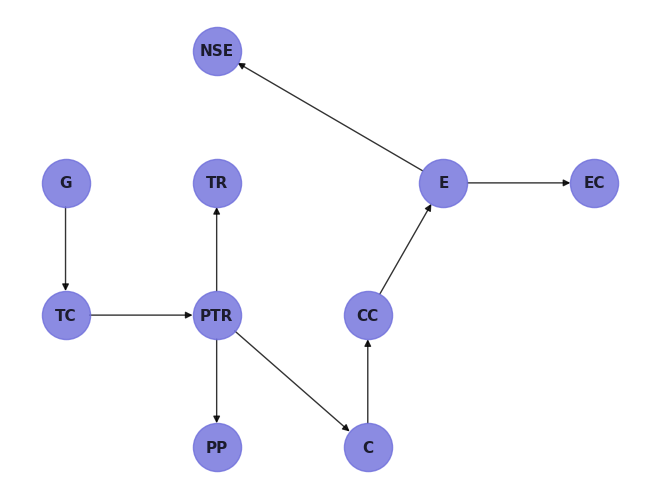

In [115]:
# Género
ts = TreeSearch(df_model, root_node='G')
dag = ts.estimate(estimator_type='chow-liu')
pos = {'NSE': (1, 1), 'TR': (1, 0), 'PTR': (1, -1), 'PP': (1, -2), 'CC': (2, -1), 'E': (2.5, 0),'G': (0, 0),'EC': (3.5, 0),'TC': (0, -1),'C': (2, -2)}
nx.draw(dag, pos=pos, with_labels=True, node_size=1200, node_color='#6e6edb', font_size=11, font_weight='bold', alpha=0.8)
plt.show()

Building tree:   0%|          | 0/45.0 [00:00<?, ?it/s]

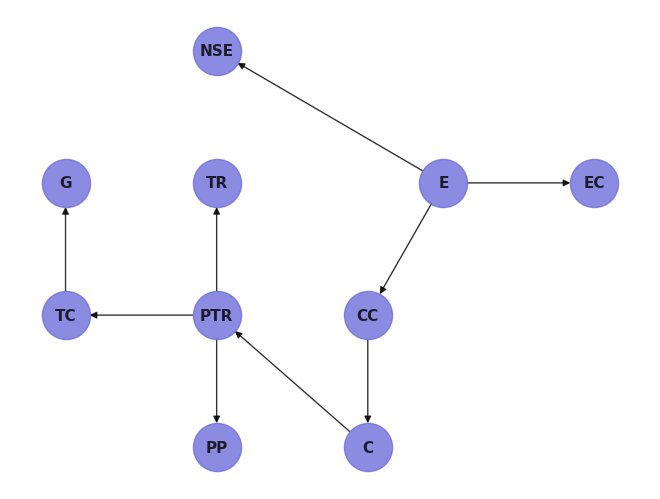

In [116]:
# Rango edad
ts = TreeSearch(df_model, root_node='E')
dag = ts.estimate(estimator_type='chow-liu')
pos = {'NSE': (1, 1), 'TR': (1, 0), 'PTR': (1, -1), 'PP': (1, -2), 'CC': (2, -1), 'E': (2.5, 0),'G': (0, 0),'EC': (3.5, 0),'TC': (0, -1),'C': (2, -2)}
nx.draw(dag, pos=pos, with_labels=True, node_size=1200, node_color='#6e6edb', font_size=11, font_weight='bold', alpha=0.8)
plt.show()

### 2.4.3. CPDs

In [117]:
bn_ = BayesianNetwork(dag)
bn_.fit(df_model)

for i in df_model.columns:
  print(i,'\n',bn_.get_cpds(i),'\n')

NSE 
 +--------+----------------------+-----+----------------------+
| E      | E(0)                 | ... | E(4)                 |
+--------+----------------------+-----+----------------------+
| NSE(0) | 0.053110221898872316 | ... | 0.23499647247955774  |
+--------+----------------------+-----+----------------------+
| NSE(1) | 0.3629198496422942   | ... | 0.5023651735424401   |
+--------+----------------------+-----+----------------------+
| NSE(2) | 0.45737844064508304  | ... | 0.21789667256514347  |
+--------+----------------------+-----+----------------------+
| NSE(3) | 0.1092518491572693   | ... | 0.03696957079907012  |
+--------+----------------------+-----+----------------------+
| NSE(4) | 0.017339638656481145 | ... | 0.007772110613788557 |
+--------+----------------------+-----+----------------------+ 

E 
 +------+------------+
| E(0) | 0.00832701 |
+------+------------+
| E(1) | 0.264378   |
+------+------------+
| E(2) | 0.323336   |
+------+------------+
| E(3) | 0.2293

# Inferencias

In [124]:
inference = VariableElimination(model)

1. ¿Cuál es la probabilidad de contar con un cliente en el nivel socioeconómico A y otro cliente en el E? (marginal)

In [125]:
p_nse = inference.query(variables=['NSE'])
print(p_nse)
print('\nLa probabilidad de que un cliente sea del NSE A es del ',round(p_nse.values[0]*100,2), "%")
print('\nLa probabilidad de que un cliente sea del NSE E es del ',round(p_nse.values[4]*100,2), "%")

+--------+------------+
| NSE    |   phi(NSE) |
+========+============+
| NSE(0) |     0.1820 |
+--------+------------+
| NSE(1) |     0.4519 |
+--------+------------+
| NSE(2) |     0.2985 |
+--------+------------+
| NSE(3) |     0.0561 |
+--------+------------+
| NSE(4) |     0.0115 |
+--------+------------+

La probabilidad de que un cliente sea del NSE A es del  18.2 %

La probabilidad de que un cliente sea del NSE E es del  1.15 %


2. ¿Cuál es la probabilidad de que un cliente se encuentre en una edad entre 36 y 45 años? (marginal)

In [126]:
p_e = inference.query(variables=['E'])
print(p_e)
print('\nLa probabilidad de que un cliente tenga entre 36-45 años es del ',round(p_e.values[2]*100,2), "%")

+------+----------+
| E    |   phi(E) |
+======+==========+
| E(0) |   0.0083 |
+------+----------+
| E(1) |   0.2644 |
+------+----------+
| E(2) |   0.3233 |
+------+----------+
| E(3) |   0.2294 |
+------+----------+
| E(4) |   0.1746 |
+------+----------+

La probabilidad de que un cliente tenga entre 36-45 años es del  32.33 %


3. ¿Cuáles son las probabilidades de que una persona del nivel socioeconómico A, B, C, D o E cuente con una tarjeta del retail? (condicional)

In [129]:
nse_list = ['A', 'B', 'C', 'D','E']

for index,value in enumerate(nse_list):
  p_nse_tr = inference.query(variables=['TR'], evidence={'NSE':index})
  print(p_nse_tr)
  print('\nLa probabilidad de que un cliente de NSE ',value,' tenga tarjeta del retail es del ',round(p_nse_tr.values[1]*100,2), '%\n')

+-------+-----------+
| TR    |   phi(TR) |
+=======+===========+
| TR(0) |    0.4015 |
+-------+-----------+
| TR(1) |    0.5985 |
+-------+-----------+

La probabilidad de que un cliente de NSE  A  tenga tarjeta del retail es del  59.85 %

+-------+-----------+
| TR    |   phi(TR) |
+=======+===========+
| TR(0) |    0.3847 |
+-------+-----------+
| TR(1) |    0.6153 |
+-------+-----------+

La probabilidad de que un cliente de NSE  B  tenga tarjeta del retail es del  61.53 %

+-------+-----------+
| TR    |   phi(TR) |
+=======+===========+
| TR(0) |    0.4272 |
+-------+-----------+
| TR(1) |    0.5728 |
+-------+-----------+

La probabilidad de que un cliente de NSE  C  tenga tarjeta del retail es del  57.28 %

+-------+-----------+
| TR    |   phi(TR) |
+=======+===========+
| TR(0) |    0.4884 |
+-------+-----------+
| TR(1) |    0.5116 |
+-------+-----------+

La probabilidad de que un cliente de NSE  D  tenga tarjeta del retail es del  51.16 %

+-------+-----------+
| TR    | 

4. ¿Cuál es la probabilidad de que un cliente que tiene tarjeta del retail la use? (condicional)

In [130]:
p_mp_tr = inference.query(variables=['PTR'], evidence={'TR':1})
print(p_mp_tr)
print('\nLa probabilidad de que un cliente que tiene tarjeta del retail lo use como medio de pago es del ',round(p_mp_tr.values[1]*100,2), "%")

+--------+------------+
| PTR    |   phi(PTR) |
+========+============+
| PTR(0) |     0.4918 |
+--------+------------+
| PTR(1) |     0.5082 |
+--------+------------+

La probabilidad de que un cliente que tiene tarjeta del retail lo use como medio de pago es del  50.82 %


5. ¿Cuál es la probabilidad de que los clientes con una edad entre 36 y 45 años sean nuevos? (condicional)

In [131]:
p_tp_e = inference.query(variables=['TC'], evidence={'E':2})
print(p_tp_e)
print('\nLa probabilidad de que un cliente que tiene entre 36 y 45 años sea nuevo es del',round(p_tp_e.values[0]*100,2), "%")

+-------+-----------+
| TC    |   phi(TC) |
+=======+===========+
| TC(0) |    0.6345 |
+-------+-----------+
| TC(1) |    0.3655 |
+-------+-----------+

La probabilidad de que un cliente que tiene entre 36 y 45 años sea nuevo es del 63.45 %


6. ¿Cuál es la probabilidad de que un cliente que compró através del canal de compra tienda física tenga un monto de compra alto? (condicional)

In [132]:
p_c_cc = inference.query(variables=['C'], evidence={'CC':0})
print(p_c_cc)
print('\nLa probabilidad de que un cliente que compró en una tienda física tenga un monto de compra alto es del',round(p_c_cc.values[2]*100,2), "%")

+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.5203 |
+------+----------+
| C(1) |   0.2234 |
+------+----------+
| C(2) |   0.2564 |
+------+----------+

La probabilidad de que un cliente que compró en una tienda física tenga un monto de compra alto es del 25.64 %


7. ¿Cuál es la probabilidad de que un cliente de género masculino, con estado civil soltero y con una edad entre 26 y 35 años vuelva a comprar ? (conjunta)

In [133]:
p_tc_gece = inference.query(variables=['TC'], evidence={'G':0,'EC':0,'E':1})
print(p_tc_gece)
print('\nLa probabilidad de que un cliente de género masculino, con estado civil soltero y con una edad entre 26 y 35 años vuelva a comprar es del',round(p_tc_gece.values[1]*100,2), "%")

+-------+-----------+
| TC    |   phi(TC) |
+=======+===========+
| TC(0) |    0.6212 |
+-------+-----------+
| TC(1) |    0.3788 |
+-------+-----------+

La probabilidad de que un cliente de género masculino, con estado civil soltero y con una edad entre 26 y 35 años vuelva a comprar es del 37.88 %


8. ¿Cuál es la probabilidad de que un cliente de nivel socioeconómico B con tarjeta de retail y con una edad entre 36 a 45 años vuelva a comprar con un rango de gasto medio? (conjunta)

In [135]:
p_c_nte = inference.query(variables=['C'], evidence={'NSE':1,'TR':1,'E':2,'TC':1})
print(p_c_nte)
print('\nLa probabilidad de que un cliente de NSE B con tarjeta de retail, con una edad entre 36 a 45 años y que ha vuelto comprar con un rango de gasto medio es del',round(p_c_nte.values[1]*100,2), "%")

+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.5732 |
+------+----------+
| C(1) |   0.2034 |
+------+----------+
| C(2) |   0.2234 |
+------+----------+

La probabilidad de que un cliente de NSE B con tarjeta de retail, con una edad entre 36 a 45 años y que ha vuelto comprar con un rango de gasto medio es del 20.34 %


# Predicciones

In [134]:
test = np.squeeze(df_model.iloc[:, -1].values)
pred = df_model.iloc[:, :-1]

y_pred = model.predict(pred)
print(accuracy_score(np.squeeze(y_pred.values), test))

  0%|          | 0/2559 [00:00<?, ?it/s]

0.5390168741266085


In [136]:
y_pred_ = bn_.predict(pred)
print(accuracy_score(np.squeeze(y_pred_.values), test))

  0%|          | 0/2559 [00:00<?, ?it/s]

0.5391955912406401
